# Faster RCNN

## Identical Setting as FAST RCNN

In [2]:
import os 
import glob
import pandas as pd
from collections import Counter 
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split


import torch

import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

from torchsummary import summary


from torchvision import models
from torchvision import transforms as T

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches

from dataload import xml_to_csv,PetData,Sub_region_train,Sub_region

from tqdm import tqdm
from utills import ssearch,misc
from utills.misc import create_label,balance_df
from metrics import iou

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [3]:
##Loading data
root_path="D:/Dataset/Pet_Data/"
#root_path="D:/Dataset/Oxford"

img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")
seed=0
df=xml_to_csv(annots,img_path)
df.head()

## Make Balanced Dataset (To save time, but don't do this in real research!!)
g = df.groupby('target')
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(),random_state=seed).reset_index(drop=True),))  
## 
train, valid = train_test_split(balanced_df, test_size=0.3,random_state=seed)  

BATCH_SIZE = 1




In [4]:
class PetData(Dataset):
    def __init__(self, dataframe,train=False,ssearch=False,samples=16):
        self.df=dataframe
        self.ssearch=ssearch
        self.transform=iaa.Sequential([iaa.Resize((224,224))])
        self.torch_transform=T.Compose([T.ToTensor(),
                                        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])    
        self.samples=samples
        self.train=train
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        regions=None
        fn,target,xmin,ymin,xmax,ymax=self.df.iloc[idx] #
        im=cv2.cvtColor(cv2.imread(fn),cv2.COLOR_BGR2RGB) ##Load Img
        
        class_label=target+1  ##Class #0 represents background
        bbs=BoundingBoxesOnImage([BoundingBox(xmin,ymin,xmax,ymax,label=class_label)], shape=im.shape) #BBox
        image_aug, bbs_aug = self.transform(image=im, bounding_boxes=bbs) #Transformation
        bbs_aug=torch.stack([torch.tensor([bb.x1,bb.y1,bb.x2,bb.y2,bb.label]) for bb in bbs_aug])
        
        region_np=[]
        img_shape=image_aug.shape      
        if self.ssearch:                                
            regions=ssearch.selective_search(image_aug, scale=50, sigma=0.8, min_size=20)
            
            if self.train:
                regions=create_label(regions,bbs_aug,iou_threshold=0.5)
                regions=[dict(t) for t in {tuple(d.items()) for d in regions}]
                for dicts in regions:
                    region_np.append((np.array(dicts['rect'],dtype=np.float)))
                region_np=np.stack(region_np)
                region_np=region_np[np.where(region_np[:,-1]>0.1)]
                
                try:
                    pos_idx = random.choices(np.where((region_np[:,4]) != 0)[0],k=16)
                except:
                    pos_idx=[]
                neg_samples=64
                if len(pos_idx):
                    neg_samples=48
                neg_idx = random.choices(np.where((region_np[:,4]) == 0)[0],k=neg_samples)
                region_np=region_np[pos_idx+neg_idx]
                region_np=torch.from_numpy(region_np)
                labels=region_np[:,4].long()
                bbox_idx=region_np[:,5].long()
                region_np=torch.stack([torch.clamp(region_np[:,0]-16,0,img_shape[1]),
                                       torch.clamp(region_np[:,1]-16,0,img_shape[0]),
                                       torch.clamp(region_np[:,2]+16,0,img_shape[1]),
                                       torch.clamp(region_np[:,3]+16,0,img_shape[0])],dim=1)
                
            else:
                regions=[dict(t) for t in {tuple(d.items()) for d in regions}]
                for dicts in regions:
                    region_np.append((np.array(dicts['rect'],dtype=np.float)))
                region_np=np.stack(region_np)
                        
                region_np=torch.from_numpy(region_np)
                region_np=torch.stack([torch.clamp(region_np[:,0]-16,0,img_shape[1]),
                                       torch.clamp(region_np[:,1]-16,0,img_shape[0]),
                                       torch.clamp(region_np[:,2]+16,0,img_shape[1]),
                                       torch.clamp(region_np[:,3]+16,0,img_shape[0])],dim=1)
                return self.torch_transform(image_aug), bbs_aug,region_np,

        return self.torch_transform(image_aug), bbs_aug,region_np,labels,bbox_idx

In [18]:
train_ds = PetData(train, train=True, ssearch=True)
valid_ds= PetData(valid, train=False,ssearch=True)

BATCH_SIZE=2
def collate_fn(batch):
    return zip(*batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=False)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

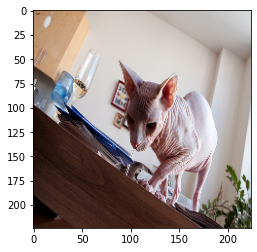

In [20]:
plt.imshow(T.ToPILImage()(train_ds[0][0]*0.5+0.5))

## Region Proposal Network

In [22]:
#Input is CONV Feature MAP

model=models.vgg16(pretrained=True).features[0:-1]

![RPN](https://i.imgur.com/QKZtjVM.png)

In [23]:
sameple_ft=model(train_ds[0][0].unsqueeze(0))


In [25]:
ANCHOR_SCALES = [8,16,32]
ANCHOR_RATIOS = [0.5,1,2]

In [14]:
print(sameple_ft.shape)

torch.Size([1, 512, 14, 14])


In [17]:
224/16

14.0